In [1]:
import os
import tarfile
import requests 
import pandas as pd


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  r = requests.get(housing_url)
  with open(tgz_path, 'wb') as code:
    code.write(r.content)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

housing = load_housing_data()
print(housing.head())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
# shows a summary of the numerical fields
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


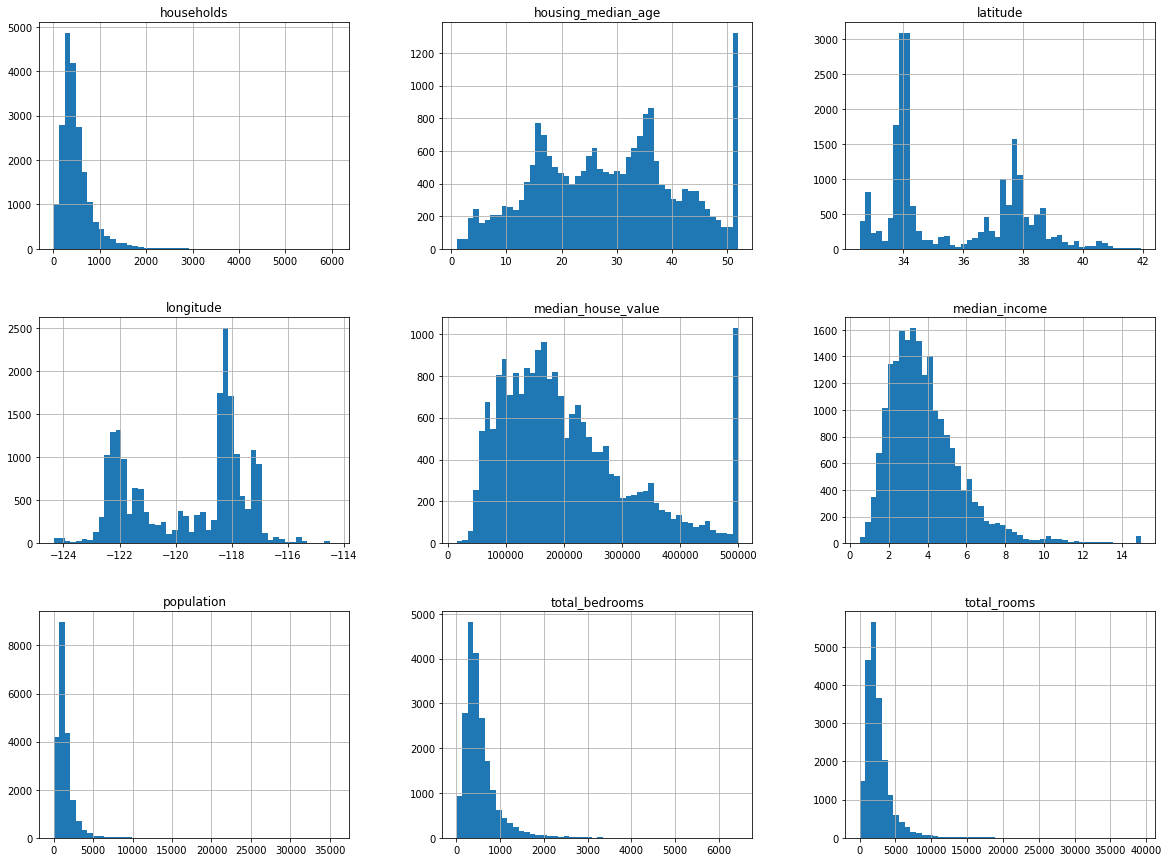

In [5]:
# Plot the data
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [6]:
# Create a test set
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42) # set the seed so that every permutaion generates the same result
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train + ", len(test_set), "test")

# Scikit-learn provides many methods to split data into train/test sets
# 1. train_test_split (random_state)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train + ", len(test_set), "test")

# The above is called random sampling, good when the number of instances is large
# but you can also run into sampling biases, we should try to keep the ratio of different type of data(man/female)...
# This is called stratified sampling, you should have not too many strata and each stratum should be large enough

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

# where replace item from other(5.0) if cond (<5) is not met
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# Do stratified sampling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_train_set = None
strat_test_set = None
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

for s in (strat_train_set, strat_test_set):
    s.drop(["income_cat"], axis=1, inplace=True)
     

16512 train +  4128 test
16512 train +  4128 test
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [7]:
## Discover and visualize the data

housing = strat_train_set.copy()
housing_labels = strat_train_set["median_house_value"].copy()
housing


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,127900.0,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,500001.0,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,140200.0,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,95000.0,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN


In [8]:
# Looking for correlation 
# compute correlation between every pair of attributes
corr_matrix = housing.corr()
corr_matrix["total_bedrooms"].sort_values(ascending=False)



total_bedrooms        1.000000
households            0.980170
total_rooms           0.929379
population            0.876320
longitude             0.076598
median_house_value    0.047689
median_income        -0.009740
latitude             -0.072419
housing_median_age   -0.325047
Name: total_bedrooms, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42bc3dda58>,
      dtype=object)

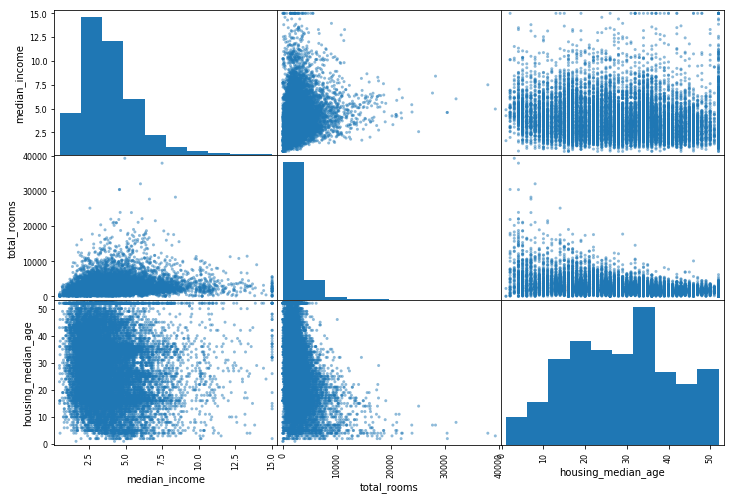

In [9]:
# Another way to check coefficients is to use pandas' scatter_matrix function
from pandas.plotting import scatter_matrix

attributes = ["median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


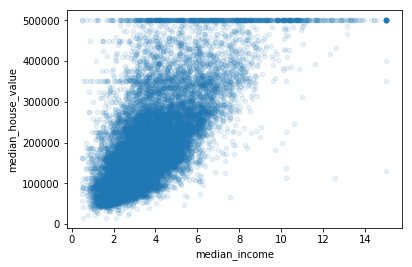

In [10]:
# we can see the most promising attribute in predicting median_house_value is median_income
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [11]:
# Experiment with attribute combinations, 
# we can create more attributes from existing ones
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedroom_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_room           -0.259984
Name: median_house_value, dtype: float64

In [12]:
## 2.5 Prepare data

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

# 2.5.1 Data cleaning
# fix missing values in columns: use DataFrame's drop() dropna() fillna() methods
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
#housing.info()

# scikit-learn has a easy to use class: Imputer to take care of missing values:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

# median can only be computed on numerical attributes
# we need to create a copy of the data without text attribtue ocean_proximity

housing_num = housing.drop("ocean_proximity", axis=1)

# now we can fit the imputer to training data using the fit() method
imputer.fit(housing_num)

# imputer calculates the median of all columns and store in its statistics_ variable
# There may be incoming data with unfilled data when the system goes live
imputer.statistics_

# now you can use this "trained" imputer to transform the data
X = imputer.transform(housing_num)

# the result X is a simple numpy array, you can put it back to pandas DataFrame:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [13]:
# 2.5.2 Handling categorical and Text attributes
# Most ML algoirthms prefer to work with numbers, so we can encode label attributes to numbers
# sklearn provides a Transformer called LabelEncoder for this kinds of task
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)

# An issue is that ML algorithms will assume two nearby values are more similar than to distant values
# we can use one-hot coding, sklean provides OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))

# housing_cat_1hot is a scipy sparse matrix: only store where the 1s are in a row:
# because we have too many 0s and very few 1s, store data in a sparse matrix will save space
#housing_cat_1hot.toarray()

# We can combine the previouse two steps in one shot by using LabelBinarizer
# but this returns a dense matrix by default
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [14]:
# 2.5.3 Custom Transformers
# duck typing, you only need to implement 3 methods:
# fit() transform() and fit_transform()
# Here is a custom transformer, adding combined attributes:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedroom_per_room=True):
        self.add_bedroom_per_room = add_bedroom_per_room
    
    def fit(self, X, y=None):
        return self; # nothing to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedroom_per_room:
            bedroom_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedroom_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedroom_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [15]:
# 2.5.4 Feature Scaling
# min-max scaling(normalization) and standardization

# min-max: [0, 1] (v - min) / (max - min)
# sklearn provides MinMaxScaler transformer for this

# standardization: subtract the mean value and then divide by the variance, so
# resulting values will have unit variance
# It does not bound values to a range, which may be a problem
# sklearn provides a StandardScaler

In [16]:
# 2.5.5 Transformation Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [17]:
# My implementation of a transformer(DataFrameSelector)
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [18]:
# This deals with numerical attributes, but we still needs to add the categorical attributes
# by applying LabelBinarizer, Sklearn provides a FeatureUnion class for this (run in parallel, concatenate)
# Because there is nothing in scikit-learn to handle pandas DataFrames, so we need to write a class
# to convert DataFrames to numpy arrays

from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
 

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [19]:
## 2.6 Select and train your model

# 2.6.1 Train and evaluate on a training set
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [20]:
# Measure the regression model's RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [21]:
# Try another model
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [22]:
# 2.6.2 better evaluation with cv
# use scikit-learn's cross validation feature
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores=np.sqrt(-scores)
rmse_scores

array([69316.02634772, 65498.84994772, 71404.25935862, 69098.46240168,
       70580.30735263, 75540.88413124, 69717.93143674, 70428.42648461,
       75888.17618283, 68976.12268448])

In [23]:
def display(scores):
    print("scores: ", scores)
    print("mean: ", scores.mean())
    print("stddev: ", scores.std())

In [24]:
display(rmse_scores)

scores:  [69316.02634772 65498.84994772 71404.25935862 69098.46240168
 70580.30735263 75540.88413124 69717.93143674 70428.42648461
 75888.17618283 68976.12268448]
mean:  70644.94463282847
stddev:  2938.9378926251234


In [26]:
# cv for linear regression
lin_scores =  cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display(lin_rmse_scores)


scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean:  69052.46136345083
stddev:  2731.674001798348


In [27]:
# Try random foreset
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22252.73894310832

In [28]:
# Use RandomForest and CV
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display(forest_rmse_scores)

scores:  [52869.23106834 49189.93801195 51726.73647871 54995.98190463
 50979.93079904 55978.43765914 52283.7609046  51001.92227546
 54447.35786983 53389.94422283]
mean:  52686.32411945208
stddev:  1971.265477949874


In [29]:
# You can save a sklearn model using python's pickle module or sklearn's joblib
from sklearn.externals import joblib


In [40]:
## 2.7 Fine tune your model
# 2.7.1 Grid Search
# In order to find the best combination of hyperparameters
# You should use scikit-learn's GridSearchCV to search for you
# you only need to tell it which parameters you want to experiment with
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

# This will search 3 * 4 and 2 * 3 combinations of parameters in the param_grid
# and it uses 5-fold cv, which will lead to 18 * 5 rounds of training
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_
                        


{'max_features': 8, 'n_estimators': 30}

In [41]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [42]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63685.69833683368 {'max_features': 2, 'n_estimators': 3}
56190.93582204183 {'max_features': 2, 'n_estimators': 10}
52945.109800049366 {'max_features': 2, 'n_estimators': 30}
61119.77043175195 {'max_features': 4, 'n_estimators': 3}
53196.369038067525 {'max_features': 4, 'n_estimators': 10}
50681.901159908964 {'max_features': 4, 'n_estimators': 30}
59780.30870560815 {'max_features': 6, 'n_estimators': 3}
52258.87852440596 {'max_features': 6, 'n_estimators': 10}
50203.9784622417 {'max_features': 6, 'n_estimators': 30}
58860.252356554694 {'max_features': 8, 'n_estimators': 3}
52085.87319584121 {'max_features': 8, 'n_estimators': 10}
50145.315636125306 {'max_features': 8, 'n_estimators': 30}
62406.446878625095 {'max_features': 2, 'n_estimators': 3, 'bootstrap': False}
54348.97009194518 {'max_features': 2, 'n_estimators': 10, 'bootstrap': False}
59522.71254488456 {'max_features': 3, 'n_estimators': 3, 'bootstrap': False}
52917.85372281318 {'max_features': 3, 'n_estimators': 10, 'bootstrap': 

In [34]:
# 2.7.2 Randomized Search
# RandomizedSearchCV

# 2.7.3 Ensemble Methods
# another way to fine-tune your system to combine the models that perform best

In [43]:
# 2.7.4 Analyse the best models and their errors
# models can indicate the relative importance of each attribute to the predicting result

feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([6.70925794e-02, 6.31400881e-02, 4.46716290e-02, 1.54831595e-02,
       1.49565250e-02, 1.56318874e-02, 1.44634425e-02, 3.68790780e-01,
       4.88858950e-02, 1.12868046e-01, 6.09759249e-02, 1.05711686e-02,
       1.55413460e-01, 1.10881448e-04, 2.65077515e-03, 4.29375838e-03])

In [44]:
# 2.7.5 Evaluate your system on the test set
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)


In [45]:
final_rmse

48127.018030387764